# A/B test

**The experiment:** A team is testing new payment mechanics on their website. The control group remained with the basic mechanics and the test group was suggested a new way of payment. 

**The task:** Analyse the results of the experiment and conclude whether it is worth launching the new payment mechanism for all users or not and why.

#### 💾 The data

There are 4 csv-files:

`groups.csv` - a table with information about the user's group (A – control, B – test group) <br>
`groups_add.csv` - an additional table with users' groups that was sent 2 days after the previous table <br>
`active_studs.csv` - a table with information about users who logged on to the platform on the days of the experiment. <br>
`checks.csv` - a table with information about user payments on the days of the experiment. <br>

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

In [22]:
# Download files

groups_url = "https://drive.google.com/uc?export=download&id=1XWYC3ogcTu7ibK6zcU5hlEA95avI1M8k"
groups_add_url = "https://drive.google.com/uc?export=download&id=1gpd79yzm40Rpq9zgz14oicu6LsmwSeLO"
active_studs_url = "https://drive.google.com/uc?export=download&id=1be1sU8LJ7nrMHrNlxwTNOILrU1TqsR_g"
checks_url = "https://drive.google.com/uc?export=download&id=1sTluLN6ol4I70I7310kKcc6z4SEzMe25"

groups = pd.read_csv(groups_url, sep=';')
groups_add = pd.read_csv(groups_add_url, sep=',')
active_studs = pd.read_csv(active_studs_url, sep=';')
checks = pd.read_csv(checks_url, sep=';')

## Preprocessing

In [26]:
# Declare the function describing basic information about our dataframes

def df_describe(df, id_col=0):
    """
    Returns information about df shape, value types, duplicates and missing values.
    
    Parameters
    ----------
    df: DataFrame object.
    id_col: int, default 0.
    """
    print(f'Shape:{df.shape} \n')
    print(f'Value types:\n{df.dtypes} \n')
    print(f'Duplicated IDs:{df.iloc[:, id_col].duplicated().sum()} \n')
    print(f'Missing values:\n{df.isna().sum()}')

In [27]:
# Look at the data

groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [28]:
df_describe(groups)

Shape:(74484, 2) 

Value types:
id      int64
grp    object
dtype: object 

Duplicated IDs:0 

Missing values:
id     0
grp    0
dtype: int64


In [29]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [30]:
df_describe(groups_add)

Shape:(92, 2) 

Value types:
id      int64
grp    object
dtype: object 

Duplicated IDs:0 

Missing values:
id     0
grp    0
dtype: int64


In [31]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [32]:
df_describe(active_studs)

Shape:(8341, 1) 

Value types:
student_id    int64
dtype: object 

Duplicated IDs:0 

Missing values:
student_id    0
dtype: int64


In [33]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [34]:
df_describe(checks)

Shape:(541, 2) 

Value types:
student_id      int64
rev           float64
dtype: object 

Duplicated IDs:0 

Missing values:
student_id    0
rev           0
dtype: int64


In [35]:
# Concat main and additional groups

groups_all = pd.concat([groups, groups_add], ignore_index=True)

In [37]:
groups_all

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [38]:
df_describe(groups_all)

Shape:(74576, 2) 

Value types:
id      int64
grp    object
dtype: object 

Duplicated IDs:0 

Missing values:
id     0
grp    0
dtype: int64


No missing values, no duplicated IDs in the whole table. Quite nice.

In [39]:
# Check the group distribution

groups_all.value_counts('grp', normalize=True)

grp
B    0.80298
A    0.19702
dtype: float64

B - treatment group.

Groups are distributed unevenly, which is standart for A/B tests, because new features are usually tested on small representative groups of users. The strange thing in this situation is that the treatment group is a lot bigger than the control group. Looks like the team has huge hopes for this new payment mechanism.

## Data exploration

In [41]:
# Look at active students' ids

active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [42]:
# Add new column

active_studs['was_active'] = True

In [43]:
active_studs.head()

,student_id,was_active
0,581585,True
1,5723133,True
2,3276743,True
3,4238589,True
4,4475369,True


In [44]:
# Merge table with group distribution and table with activity info

groups_all = groups_all.merge(active_studs, left_on='id', right_on='student_id', how='left')

In [45]:
# Get rid of unnecessary column

groups_all.drop(columns=['student_id'], inplace=True)

In [46]:
groups_all['was_active'].fillna(False, inplace=True)

In [47]:
groups_all

,id,grp,was_active
0,1489,B,False
1,1627,A,True
2,1768,B,False
3,1783,B,False
4,1794,A,False
...,...,...,...
74571,200247820,B,False
74572,201032527,B,False
74573,201067612,B,False
74574,201067653,B,False


In [48]:
# Check for incorrect values (zero in revenue is incorrect in our situation)

checks[checks['rev'] == 0]

,student_id,rev


In [49]:
# Final table with all the data about our users

groups_all = groups_all.merge(checks, left_on='id', right_on='student_id', how='left')

In [50]:
# Get rid of unnecessary column (again)

groups_all.drop(columns=['student_id'], inplace=True)

In [51]:
# Fill NaN revenues with zeros

groups_all['rev'].fillna(0, inplace=True)

In [52]:
groups_all.head()

,id,grp,was_active,rev
0,1489,B,False,0.0
1,1627,A,True,990.0
2,1768,B,False,0.0
3,1783,B,False,0.0
4,1794,A,False,0.0


In [53]:
df_describe(groups_all)

Shape:(74576, 4) 

Value types:
id              int64
grp            object
was_active       bool
rev           float64
dtype: object 

Duplicated IDs:0 

Missing values:
id            0
grp           0
was_active    0
rev           0
dtype: int64


In [69]:
# Look at the users who made a purchase

groups_all[groups_all['rev'] > 0]

,id,grp,was_active,rev
1,1627,A,True,990.0
39,3185,B,False,690.0
121,25973,B,False,690.0
125,26280,B,False,690.0
220,100300,B,True,990.0
...,...,...,...,...
74365,5645737,B,True,1900.0
74381,5651566,B,True,1900.0
74402,5662322,B,True,1900.0
74452,5681918,B,True,1900.0


In [138]:
# Number of users who made a purchase but was unactive during the experiment

unactive = groups_all.query("rev > 0 and was_active == False")
unactive.shape[0]

149

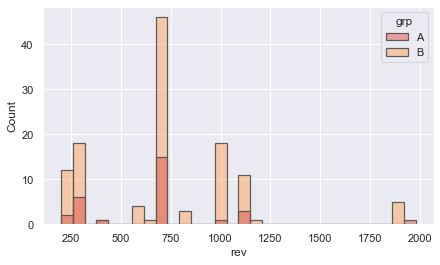

In [232]:
# Histogram of their spendings

plt.figure(figsize=(7,4))
sns.set(style="darkgrid", palette="Spectral")
sns.histplot(data=unactive, x="rev", hue="grp", hue_order=["A", "B"], bins=30, edgecolor="#5a5a58", linewidth=1.2)
plt.show()

There're no any obvious patterns in unactive users' spendings and since they haven't used the product during the experiment, two assumptions can be made:
1. The product also has a subscription payment, which was charged from users;
2. This is a logging error and these users were actually active on the platform, but for some reason did not get into our `active_users` dataset.

I'll assume the option 1 to be the case and filter unactive users because their behaviour was not affected by the new mechanics that was suggested.

In [150]:
# Filter unactive users 

groups_active = groups_all.query('was_active == True')

In [151]:
# Look at the median revenue of two groups

groups_active.groupby(['grp'], as_index=False) \
             .agg({'id': 'nunique', 'rev': 'median'}) \
             .rename(columns={'id': 'grp_size'})

,grp,grp_size,rev
0,A,1538,0.0
1,B,6803,0.0


In [152]:
# Look at the mean revenue of two groups

groups_active.groupby(['grp'], as_index=False) \
             .agg({'id': 'nunique', 'rev': 'mean'}) \
             .rename(columns={'id': 'grp_size'})

,grp,grp_size,rev
0,A,1538,47.347204
1,B,6803,58.058798


What we see so far is:
* Users are unevenly distributed into groups at 20/80 ratio;
* More than half of users didn't buy anything (median = 0);
* There're otliers, who spent a lot;
* Revenue distribution is right-skewed with most transactions at point zero.

In [153]:
# Let's look at the distributions

In [241]:
# Create a function for visualisation

def revenue_dist_vis(df):
    """
    Visualises revenue distribution in three ways: histogram, violinplot, and boxplot.
    
    Parameters
    ----------
    df: DataFrame object.
    """
    
    fig, axs = plt.subplots(nrows=1, ncols=3, 
                       constrained_layout=True, 
                       figsize=(12, 5), dpi=300)

    sns.set(style="darkgrid", palette="Spectral")

    sns.histplot(data=df, x="rev", hue="grp", bins=30, edgecolor="#5a5a58", linewidth=1.2, ax=axs[0])
    sns.violinplot(data=df, x="rev", y="grp", linewidth=1.5, ax=axs[1])
    sns.boxplot(data=df, x="rev", y="grp", ax=axs[2])

    axs[0].set(xlabel="", ylabel="")
    axs[1].set(xlabel="", ylabel="")
    axs[2].set(xlabel="", ylabel="")

    fig.suptitle('Revenue distribution in groups A and B \n', fontsize=16)
    fig.text(0.5, -0.04, 'Revenue Units', ha='center')

    plt.show()

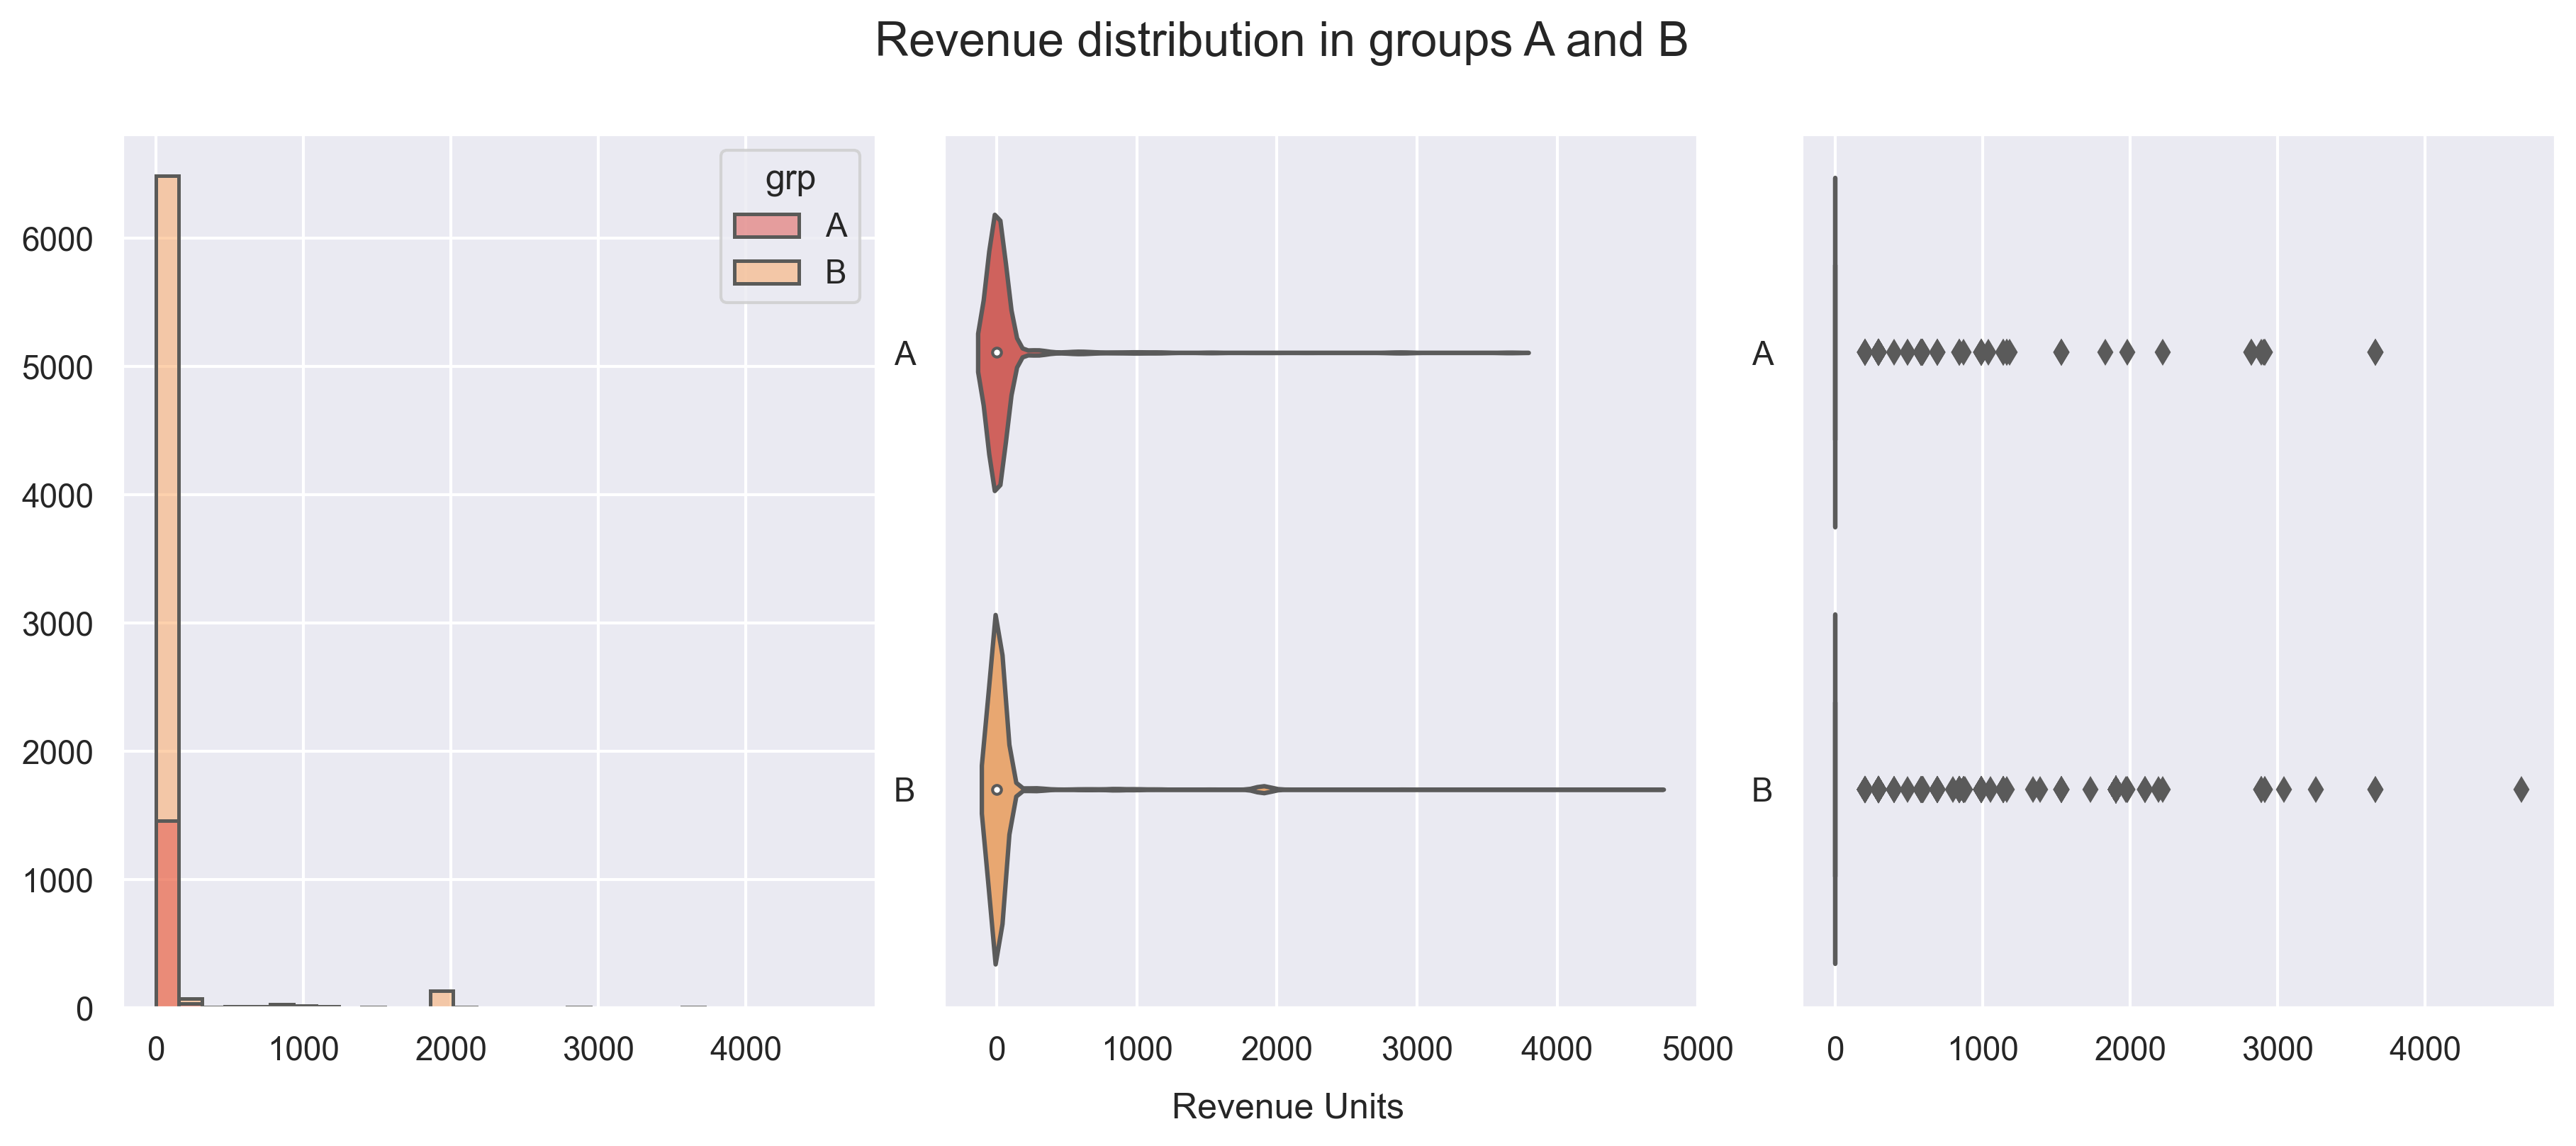

In [242]:
# Revenue distribution of active users

revenue_dist_vis(groups_active)

As expected, revenue distribution is right-skewed with extreme outliers. Visualisation of revenue from active users doesn't give much information about it because outliers make them hard to read. Let's look at the distribution of revenue from users who made a purchase.

In [156]:
# Filter users who didn't buy anything

groups_payed = groups_active.query('rev > 0')

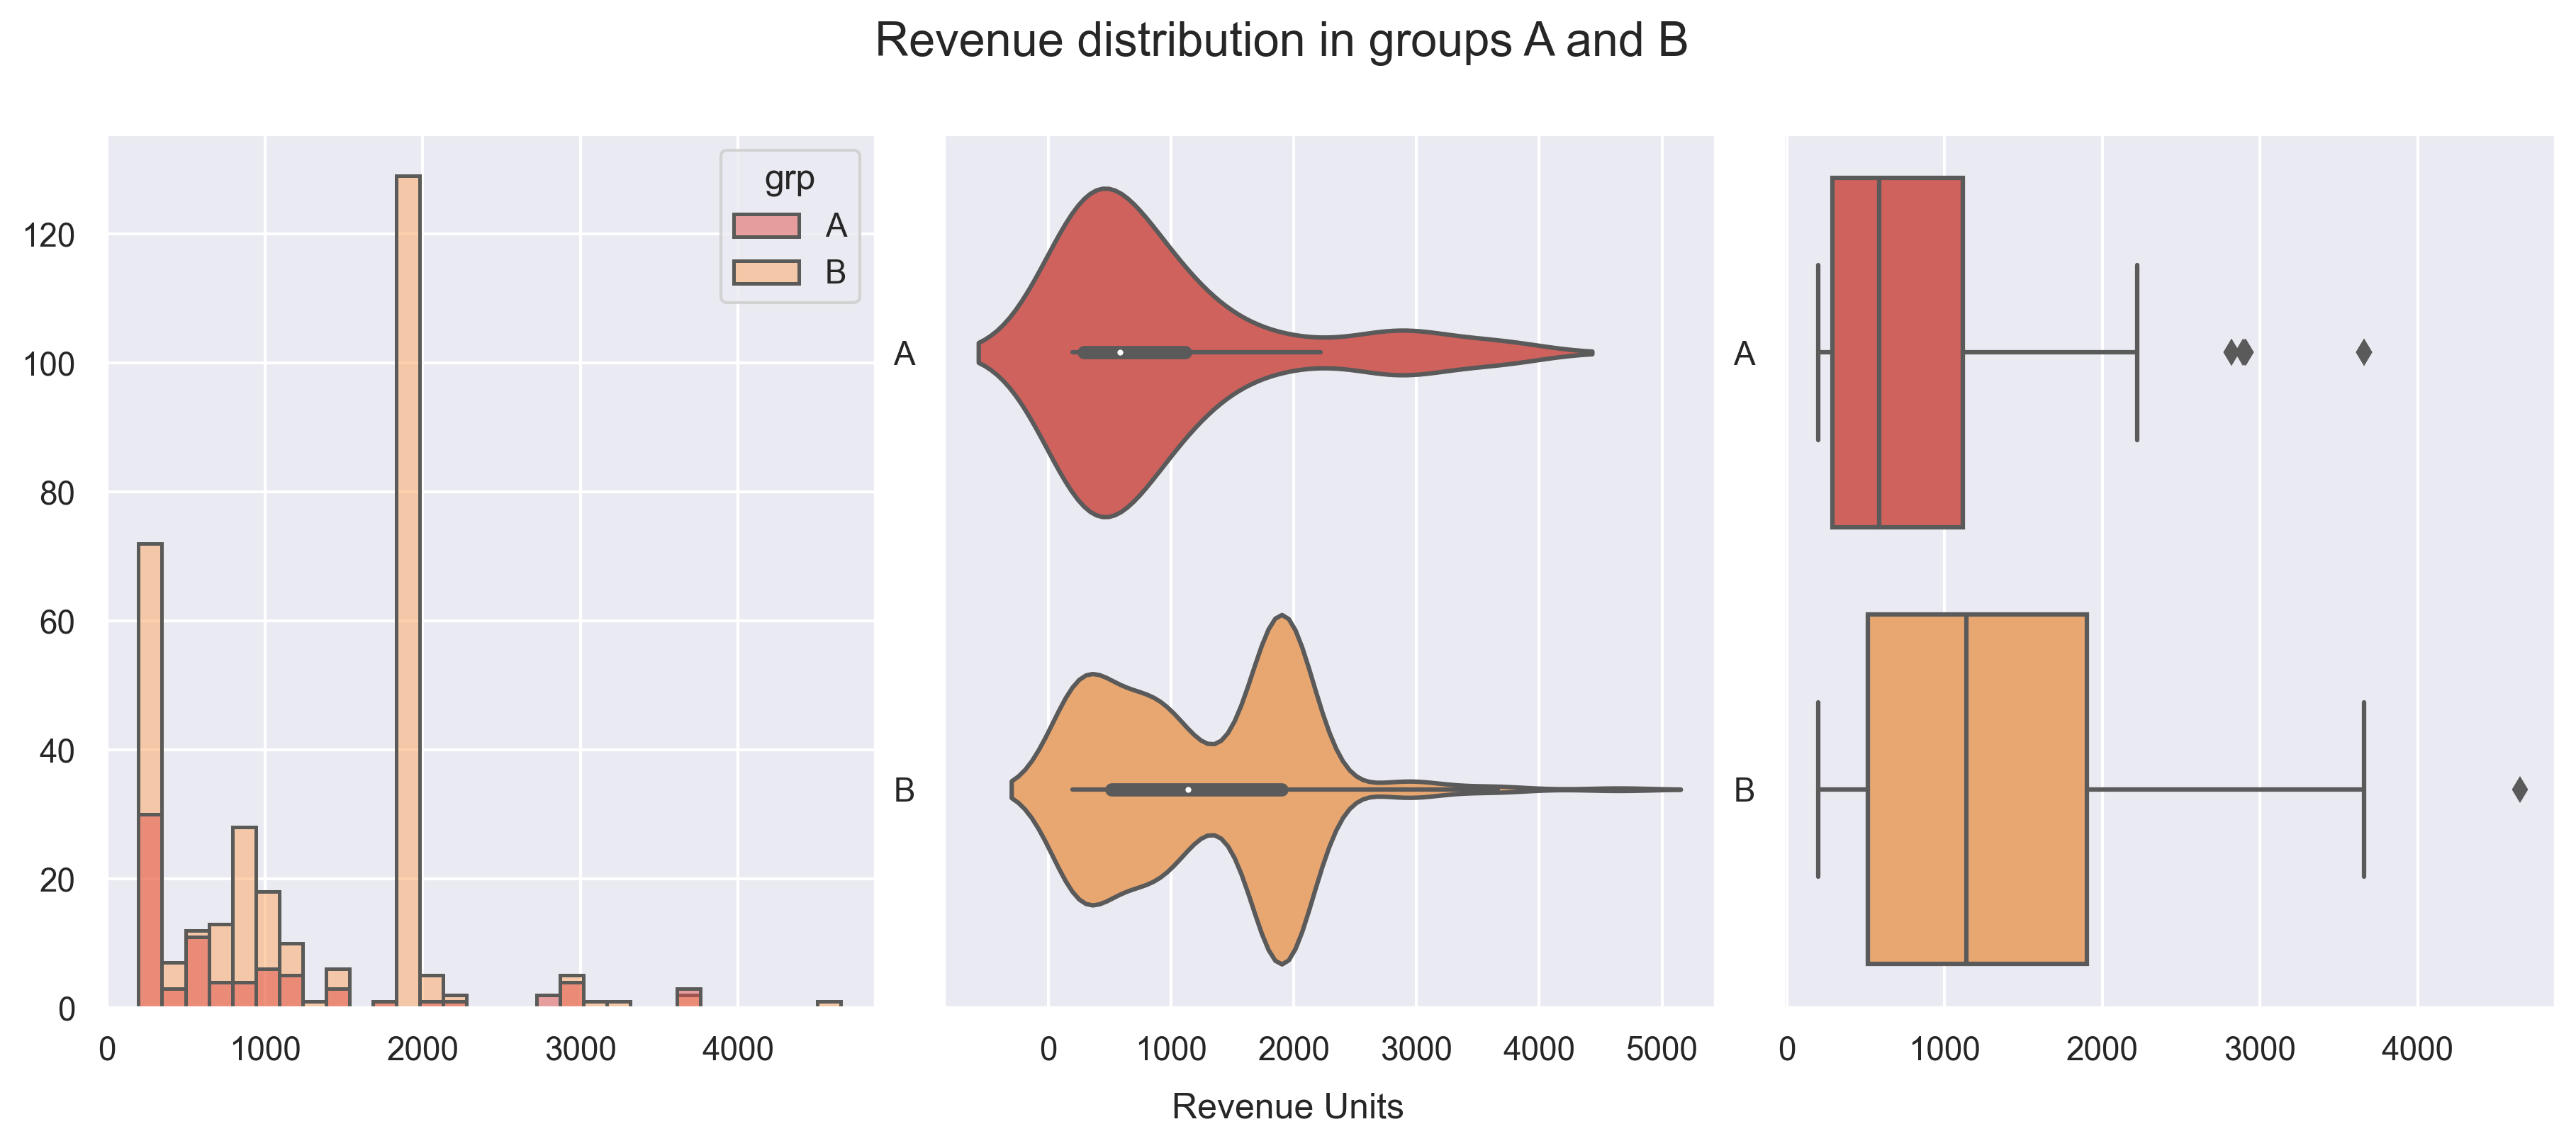

In [157]:
# Revenue distribution of paying users

revenue_dist_vis(groups_payed)

Looks a lot better now. We can see that both distributions are far from normal: group A is unimodal and right-skewed, group B is bimodal, right-skewed and has a higher variance. Group B's median is higher than group A's. I don't know what actual change in the payment mechanics was introduced, I only have the data, but it clearly makes more people pay ~2000 for a purchase rather than ~500. Probably, the team started selling bundles of courses or started suggesting to buy additional courses when you buy one, giving extra discounts for them or partnered with a credit organisation and now suggests a loan and users can afford more, or a mix of all of that.

## Hypothesis testing

First, let's look at some metrics that affect the revenue and then decide which of them to focus on and test.

In [158]:
# Calculate some metrics and compare them between two groups

In [159]:
def get_metrics(data):
    """
    Calculates the next metrics by group:
    - number of all registered users
    - number of active users
    - number of paying users
    - CR,% (visit -> purchase)
    - ARPAU (average revenue per active user)
    - ARPPU (average revenue per paying user)
    
    Parameters
    ----------
    data: DataFrame object.
    """

# number of all users in the groups (A - control, B - treatment)
    metrics = data.groupby('grp', as_index=False).agg({'id': 'nunique'}).rename(columns={'id': 'users'})
    
# number of active users
    metrics['active_users'] = data.query('was_active == True') \
                             .groupby('grp', as_index=False).agg({'id': 'nunique'}).id
    
# number of paying users
    metrics['paying_users'] = data.query('rev > 0') \
                             .groupby('grp', as_index=False).agg({'id': 'nunique'}).id
    
# CR from visitor to customer
    metrics['CR, %'] = metrics.paying_users.div(metrics.active_users).multiply(100).round(3)

# ARPAU
    metrics['ARPAU'] = data.groupby('grp', as_index=False).agg({'rev': 'sum'}).rev \
                     .div(metrics.active_users).round(3)
# ARPPU
    metrics['ARPPU'] = data.groupby('grp', as_index=False).agg({'rev': 'sum'}).rev \
                      .div(metrics.paying_users).round(3)   

    
# Final table with metrics
    metrics.set_index('grp', inplace=True)
    metrics = metrics.transpose()
    metrics['Diff'] = metrics.B - metrics.A

    return metrics

In [160]:
get_metrics(groups_all)

grp,A,B,Diff
users,14693.000,59883.000,45190.000
active_users,1538.000,6803.000,5265.000
paying_users,107.000,434.000,327.000
"CR, %",6.957,6.380,-0.577
ARPAU,59.880,70.738,10.858
ARPPU,860.710,1108.825,248.115


Based on the table:
* There're a lot more users in group B than in group A, in any subgroup
* Average revenue for both active and and paying users is higher in group B (treatment group)
* Conversion rate from visit to purchase is higher in group A (control)

The metrics I suggest testing are **ARPAU (average revenue per active user)** to check whether the new mechanics increases revenue from all active users, **ARPPU (average revenue per paying user)** to check whether the difference of ~250 units is statistically significant and **CR (conversion rate)**, which went down for the treatment group and is rather alarming. They were selected because they are standard product metrics and are the main metrics affecting the product's income.

### Hypothesis 1. Revenue group A (active users) == Revenue group B (active users)

$H_{0}: ARPAU_{A} = ARPAU_{B}$<br>
$H_{1}: ARPAU_{A} \not= ARPAU_{B}$

Even though the data is not normally distributed, I'll use Welch's t-test because of the following reasons:
* it's easy to interpret for business (tests whether the means of two populations are different);
* the sample size is large enough for the sample means to be well-approximated by a normal distribution;
* it doesn't require homogenious variances (as oppposed to the Student's t test) for the results to be reliable;
* sample sizes are unequal, so it's more efficient to perform Welch's t-test unconditionally, without regard to the variability of sample values.

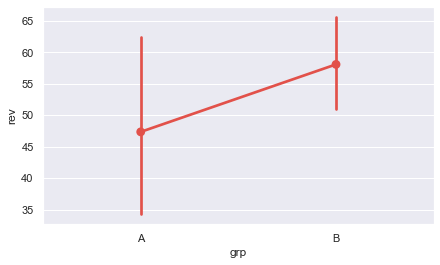

In [237]:
# Take a look at the pointplot

plt.figure(figsize=(7,4))
sns.pointplot(x="grp", y="rev", data=groups_active)
plt.show()

In [66]:
# Run the Welch's t-test

stats.ttest_ind(groups_active[groups_active['grp'] == 'A'].rev, 
                groups_active[groups_active['grp'] == 'B'].rev,
                equal_var=False)

Ttest_indResult(statistic=-1.286373849379703, pvalue=0.19843583641451018)

P-value > 0.05, cannot reject $H_{0}$. Hence, revenues from users who were active during the experiment don't differ.

### Hypothesis 2. Revenue group A (paying users) == Revenue group B (paying users)

$H_{0}: ARPPU_{A} = ARPPU_{B}$<br>
$H_{1}: ARPPU_{A} \not= ARPPU_{B}$

Let's look at the users who made a purchase. For ARPPU I'll use Welch's t-test for the same reasons I've used it for ARPAU.

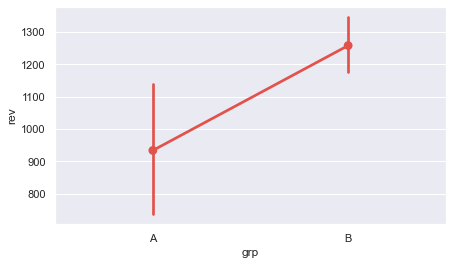

In [243]:
# Take a look at the pointplot

plt.figure(figsize=(7,4))
sns.pointplot(x="grp", y="rev", data=groups_payed)
plt.show()

In [244]:
# Run the Welch's t-test

stats.ttest_ind(groups_payed[groups_payed['grp'] == 'A'].rev, 
                groups_payed[groups_payed['grp'] == 'B'].rev,
                equal_var=False)

Ttest_indResult(statistic=-2.861689755269415, pvalue=0.005069734012800116)

P-value < 0.05, reject $H_{0}$. Revenues from paying customers, unlike from active ones, did increase. So, users didn't start spending more on average, but those who did spent significantly more. 

### Hypothesis 3. CR (active -> purchase) group A == CR (active -> purchase) group B

$H_{0}: CR_{A} = CR_{B}$<br>
$H_{1}: CR_{A} \not= CR_{B}$

In [245]:
# Create a data frame with categorical variable 'converted'
# 0 - didn't convert, 1 - converted

cr_df = groups_active.copy()
cr_df['converted'] = cr_df['rev'].apply(lambda x: x if x == 0 else 1).astype(int)
cr_df.head()

,id,grp,was_active,rev,converted
1,1627,A,True,990.0,1
10,2085,B,True,0.0,0
12,2215,B,True,0.0,0
43,3391,A,True,0.0,0
45,3401,B,True,0.0,0


In [246]:
# Split df into two groups

cr_df_a = cr_df.query('grp == "A"').converted
cr_df_b = cr_df.query('grp == "B"').converted

In [226]:
# Run chi-squared test

array = np.array([[cr_df_a.sum(), cr_df_a.count()], [cr_df_b.sum(), cr_df_b.count()]])
chi2, p, dof, ex = stats.chi2_contingency(array, correction=False)

In [227]:
p

0.4672642540463894

P-value > 0.05, cannot reject $H_{0}$. The test didn't find any difference in conversion rate between groups. 

In [228]:
# Look at the metrics table once again

get_metrics(groups_all)

grp,A,B,Diff
users,14693.000,59883.000,45190.000
active_users,1538.000,6803.000,5265.000
paying_users,107.000,434.000,327.000
"CR, %",6.957,6.380,-0.577
ARPAU,59.880,70.738,10.858
ARPPU,860.710,1108.825,248.115


### Summary:
* $ARPAU_{A} = ARPAU_{B}$. The new mechanics **didn't increase the average revenue from users who were active** during the experiment.
* $ARPPU_{A} \not= ARPPU_{B}$. The mechanics **increased the average revenue from buying users**. The distribution showed that there were more purchases for 2000 rather than for 500. The purchases "switched" to higher checks.
* $CR_{A} = CR_{B}$. **Conversion rate difference was statistically insignificant**, but in absolute values it **went down** for treatment group B, which is alarming.

### Overall recommendation:
I **don't recommend** implementing the new mechanics for all users at the moment because the pros are not very strong. It does increase average revenue per paying user but the conversion rate went down by 0.6 percentage point in our sample (even though it was statistically insignificant), which shouldn't be left unattended because the increased revenues might not cover the loss in CR. Hence, the **company should continue the experiment and keep CR in control**. It's possible that with more data the conversion rates will level off.